In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

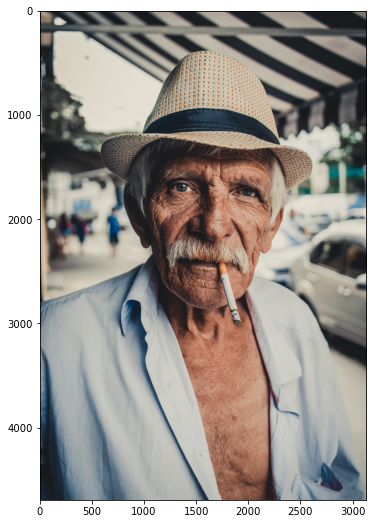

In [2]:
import cv2
# load in color image for face detection
image = cv2.imread('data/pexels-thgusstavo-santana-1933873.jpg')# https://www.pexels.com/photo/man-with-cigarette-in-mouth-1933873/

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

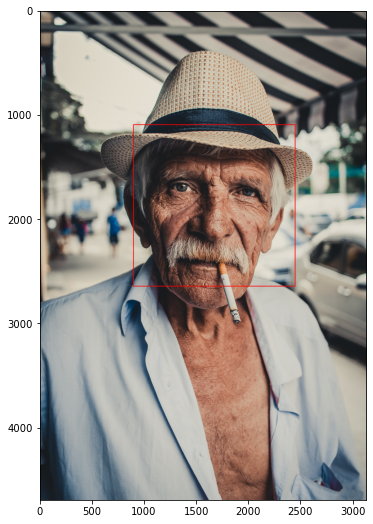

In [3]:
face_cascade = cv2.CascadeClassifier("data/haarcascade_frontalface_default.xml")

# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.01, 3, minSize =[1200, 1200])

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),6) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = 'trained_model.pth'
model = torch.load(PATH)
model.to(device)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Linear1): Linear(in_features=80000, out_features=512, bias=True)
  (Linear2): Linear(in_features=512, out_features=256, bias=True)
  (Linear3): Linear(in_features=256, out_features=136, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

In [5]:
def show_all_keypoints(image, predicted_key_pts):
    '''
    Plot Image with keypoints
    Args: 
        image : Image data
        predicted_key_pts : Predicted Keypoints
    '''
    # image is grayscale
    plt.figure(figsize=(20,10))
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

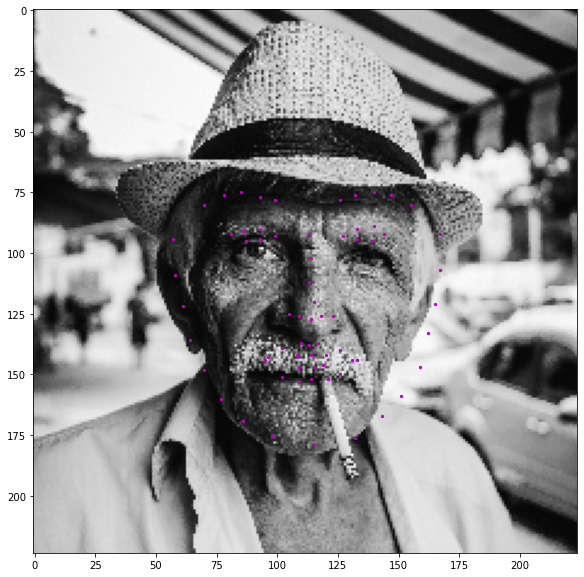

In [6]:
image_copy = np.copy(image)
# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    margin = int(w*0.5)
    roi = image_copy[max(y-margin,0):min(y+h+margin,image.shape[0]), 
                 max(x-margin,0):min(x+w+margin,image.shape[1])]
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    roi_gray_norm = roi_gray/255.0
    roi_gray_norm = cv2.resize(roi_gray_norm, (224,224))

    torch_roi = torch.unsqueeze(torch.tensor(roi_gray_norm), dim = 0)
    torch_roi = torch.unsqueeze(torch_roi, dim = 0)
    torch_roi = torch_roi.float()
    torch_roi = torch_roi.to(device)

    predicted_key_pts = model(torch_roi)
    predicted_key_pts = predicted_key_pts.view(predicted_key_pts.size()[0], 68, -1)
    predicted_key_pts = predicted_key_pts.detach().cpu().numpy()
    predicted_key_pts = predicted_key_pts*50.0+100
    predicted_key_pts = np.squeeze(predicted_key_pts.astype(int))
     
    show_all_keypoints(roi_gray_norm, predicted_key_pts)